# Convolutional Autoencoder in Keras for EEG

Autoencoder is a neural network which consists of two parts: 
* encoder,
* decoder, 

both are neural networks. 

In the work we create contractive autoencoder. It means that the layer between encoder and decoder has less neurons than an input layer. It is aimed to reduce input data diminution space and delete the noise with valuable information extraction. 

Decoder transforms reduced representation to the target representation.

__Representation of EEG data__

In [1]:
import numpy as np
import mne

%matplotlib inline

raw = mne.io.read_raw_brainvision("data/zavrin_open_eyes_eeg_15021500.vhdr")
data = raw.get_data()
data.shape

Extracting parameters from data/zavrin_open_eyes_eeg_15021500.vhdr...
Setting channel info structure...


(61, 302000)

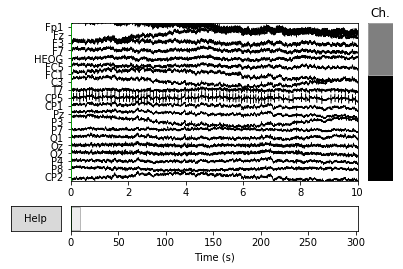

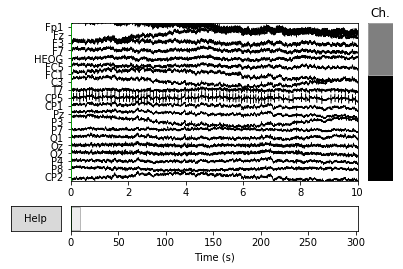

In [2]:
raw.plot()

__We will train our model not on the full length of files, but dividing them into batches__

Here is an example of 20 s segment of the data

(61, 20000)
[ 100.     100.001  100.002 ...,  119.997  119.998  119.999]


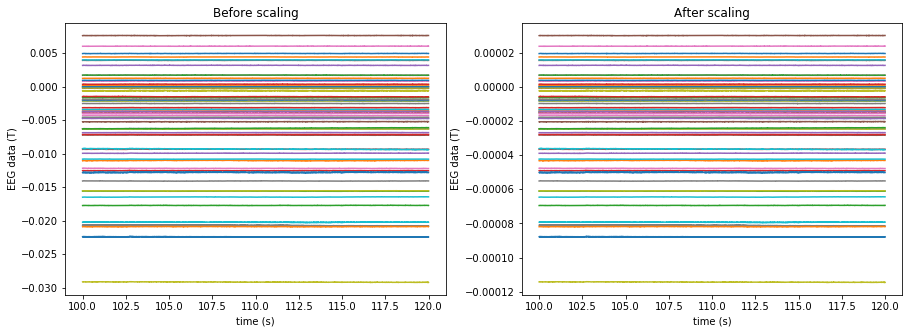

In [7]:
import matplotlib.pyplot as plt
start, stop = raw.time_as_index([100, 120])  # 100 s to 120 s data segment
data, times = raw[:, start:stop]
print(data.shape)
print(times)
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(times, data.T)
plt.xlabel('time (s)')
plt.ylabel('EEG data (T)')
plt.title('Before scaling')

plt.subplot(1,2,2)
plt.plot(times, data.T.astype('float32')/255.)
plt.xlabel('time (s)')
plt.ylabel('EEG data (T)')
plt.title('After scaling')
plt.show()

## CNN AE

The encoder will consist in a stack of Conv1D and MaxPooling1D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv1D and UpSampling1D layers.

In the proccess different hyperparameters were tuned, such as *number of filters*, *filter lengths*, *length of batch* and others.
### Model
* Input &mdash; (channels_num = 61, window_size = 500, 1)

#### Encoder

    * Conv1D(nb_filters = 64, filter_length = 5) + ReLU ---- (channels_num = 61, window_size = 500, 64)
    * MaxPooling1D ----------------------------------------- (channels_num = 61, window_size = 250, 64)
    * Conv1D(nb_filters = 32, filter_length = 5) + ReLU ---- (channels_num = 61, window_size = 250, 32)
    * MaxPooling1D ----------------------------------------- (channels_num = 61, window_size = 125, 32)
    * Dense + ReLU ----------------------------------------- (channels_num = 61, window_size = 125, 1)

#### Decoder

    * Conv1D(nb_filters = 32, filter_length = 5) + ReLU ---- (channels_num = 61, window_size = 125, 32)
    * UpSampling1D ----------------------------------------- (channels_num = 61, window_size = 250, 32)
    * Conv1D(nb_filters = 64, filter_length = 5) + ReLU ---- (channels_num = 61, window_size = 250, 64)
    * UpSampling1D ----------------------------------------- (channels_num = 61, window_size = 500, 64)
    * Conv1D(nb_filters = 64, filter_length = 5) + Sigmoid - (channels_num = 61, window_size = 500, 1)


* Output &mdash; (channels_num = 61, window_size = 500, 1)

In [8]:
from keras.layers import Input, Conv1D, Dense, MaxPooling1D, Dropout, UpSampling1D
from keras.models import Model
from keras.models import Sequential
from keras import backend as K

channels_num = 61
nb_filter_1 = 64
nb_filter_2 = 32
filter_length = 5

window_size = 500
encoding_dim = 1

input_ = Input(shape=(window_size, 1))

encoder = Sequential((
    Conv1D(nb_filter=nb_filter_1, filter_length=filter_length, activation='relu', padding='same', input_shape=(window_size, 1)),
    Dropout(0.4),
    MaxPooling1D(),
    Conv1D(nb_filter=nb_filter_2, filter_length=filter_length, activation='relu', padding='same'),
    MaxPooling1D(),
    Dense(encoding_dim, activation='relu')
))
encoder.summary()
print(encoder.output_shape)
decoder = Sequential((
    Conv1D(nb_filter=nb_filter_2, filter_length=filter_length, activation='relu', padding='same', input_shape=encoder.output_shape[-2:]),
    UpSampling1D(),
    Conv1D(nb_filter=nb_filter_1, filter_length=filter_length, padding='same', activation='relu'),
    UpSampling1D(),
    Conv1D(nb_filter=1, filter_length=filter_length, padding='same', activation='sigmoid')
))
decoder.summary()
autoencoder = Model(input_, decoder(encoder(input_)), name="autoencoder")
autoencoder.compile(loss='mse', optimizer='adam', metrics=['mae']) # .compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

Using TensorFlow backend.
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", padding="same", input_shape=(500, 1), filters=64, kernel_size=5)`
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", padding="same", filters=32, kernel_size=5)`
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", padding="same", input_shape=(125, 1), filters=32, kernel_size=5)`
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(padding="same", activation="relu", filters=64, kernel_size=5)`
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv1D` c

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 500, 64)           384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 250, 32)           10272     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 125, 32)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 125, 1)            33        
Total params: 10,689
Trainable params: 10,689
Non-trainable params: 0
_________________________________________________________________
(None,

### Batch Generator

To fit our model we need to define batch_generator, so that on every step we could choose random 0.5 s interval from the dataset.

__ForThreadSafety:__

In [9]:
import threading
class threadsafe_iter:
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()
    def __iter__(self):
        return self
    def __next__(self):
        with self.lock:
            return next(self.it)

def threadsafe_generator(f):
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

__And now to the generator.__ 

First we will separate one file for validation test. 
Then define *batch\_length (window\_size)* for our data.

At the each step, the file and batch from the file will be chosen randomly. 

In [16]:
import glob
files_ = glob.glob("data/*.vhdr")
file_test_ind = np.random.choice(np.arange(len(files_)))
file_test_ = files_[file_test_ind]
files_.pop(file_test_ind)

batch_length = 0.5 # 0.5 s of data segment
random_rate = 0.5

raw = mne.io.read_raw_brainvision(file_test_, preload=True)
iters = []
for i in range(int(raw.get_data().shape[1] / 1e3 / batch_length)):
    start, stop = raw.time_as_index([i * batch_length, (i + 1) * batch_length])
    iters.append((start, stop))
x_tests = [raw[:, start:stop][0] for start, stop in iters]

@threadsafe_generator
def generate_batch():
    while True:
        cur_files = [[] for _ in range(len(files_))]
        batches = [[] for _ in range(len(files_))]
        files_count = len(files_)
        while files_count > 0:
            file_ind = np.random.choice(np.arange(len(files_)))
            if cur_files[file_ind] == -1: continue
            if not cur_files[file_ind]:
                raw = mne.io.read_raw_brainvision(files_[file_ind], preload=True)
                cur_files[file_ind] = raw
                batches[file_ind] = np.arange(int(raw.get_data().shape[1] / 1e3 / batch_length))
            begin = np.random.choice(np.arange(len(batches[file_ind])))
            
            start, stop = cur_files[file_ind].time_as_index([batches[file_ind][begin] * batch_length, (batches[file_ind][begin] + 1) * batch_length])
            data, times = cur_files[file_ind][:, start:stop]
            data += random_rate * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
            yield (np.expand_dims(data, axis=2).astype('float32')/255., np.expand_dims(data, axis=2).astype('float32')/255.) # add noise later
            
            batches[file_ind] = np.delete(batches[file_ind], begin)
            if len(batches[file_ind]) == 0:
                cur_files[file_ind] = -1
                files_count -= 1

Extracting parameters from data/dagaev_post_rest_eeg_30011600.vhdr...
Setting channel info structure...
Reading 0 ... 603799  =      0.000 ...   603.799 secs...


### Let's fit our Model

In [18]:
history = autoencoder.fit_generator(generate_batch(), samples_per_epoch=int(150 / batch_length) * len(files_), nb_epoch=3, validation_data=(np.expand_dims(x_tests[123], axis=2).astype('float32')/255., np.expand_dims(x_tests[123], axis=2).astype('float32')/255.))

Extracting parameters from data/zavrib_post_eeg_eyesopen15021500.vhdr...Epoch 1/3

Setting channel info structure...
Reading 0 ... 321599  =      0.000 ...   321.599 secs...


/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., validation_data=(array([[[..., steps_per_epoch=9300, epochs=3)`
  """Entry point for launching an IPython kernel.


Extracting parameters from data/gorbacheva_03_02_2017_post_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 603949  =      0.000 ...   603.949 secs...
Extracting parameters from data/miloslavov_22_05_pre_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 603399  =      0.000 ...   603.399 secs...
Extracting parameters from data/300120171600_dagaev_rest_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 17020099  =      0.000 ... 17020.099 secs...
Extracting parameters from data/2103_kozunova_post_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 603199  =      0.000 ...   603.199 secs...
Extracting parameters from data/zavrin_open_eyes_eeg_15021500.vhdr...
Setting channel info structure...
Reading 0 ... 301999  =      0.000 ...   301.999 secs...
Extracting parameters from data/bagaeva_post_eeg_13031500.vhdr...
Setting channel info structure...
Reading 0 ... 603899  =      0.000 ...   603.899 secs...
Extracting parameters from data/2003_ivanova_pos

In [19]:
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


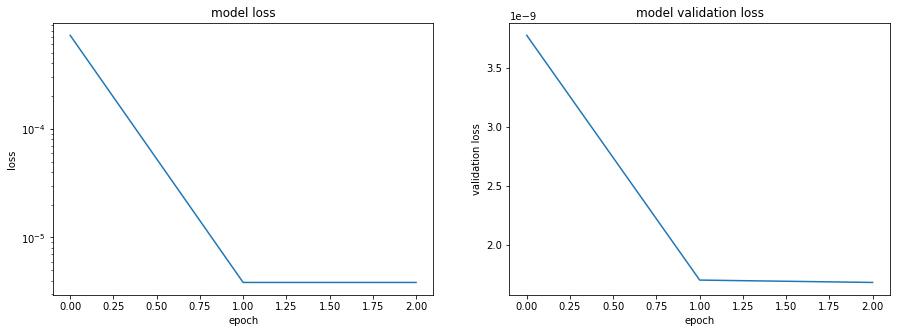

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.show()

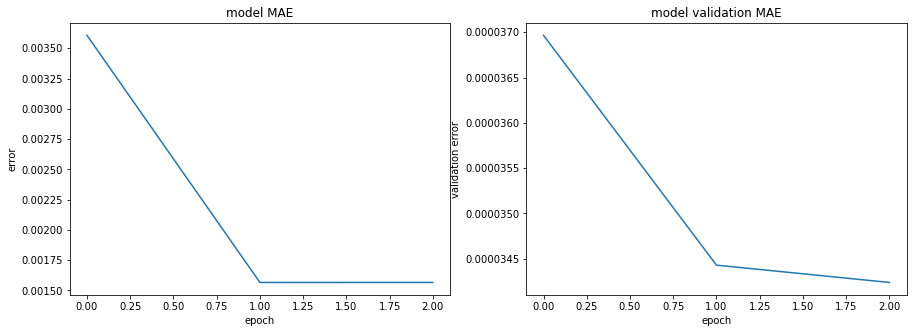

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('error')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model validation MAE')
plt.ylabel('validation error')
plt.xlabel('epoch')
plt.show()

In [24]:
import types
import tempfile
import keras.models
import pickle
import mne as mn
from sklearn.metrics import mean_squared_error

In [25]:
def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = keras.models.load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

In [26]:
make_keras_picklable()
pickle.dump(encoder, open("encoder.p", "wb"))
pickle.dump(decoder, open("decoder.p", "wb"))

In [30]:
load_encoder = pickle.load(open("encoder.p", "rb"))
load_decoder = pickle.load(open("decoder.p", "rb"))
x_reduce = load_encoder.predict(np.expand_dims(x_tests[321], axis=2).astype('float32')/255.)
alpha = x_reduce.shape[1] / 64
x_pred = load_decoder.predict(x_reduce)
mse = mean_squared_error(x_tests[321].astype('float32')/255.,x_tests[321].astype('float32')/255.)
score = (1 + mse) * alpha

print(score)

/opt/conda/anaconda3/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1.953125


(61, 500, 1)


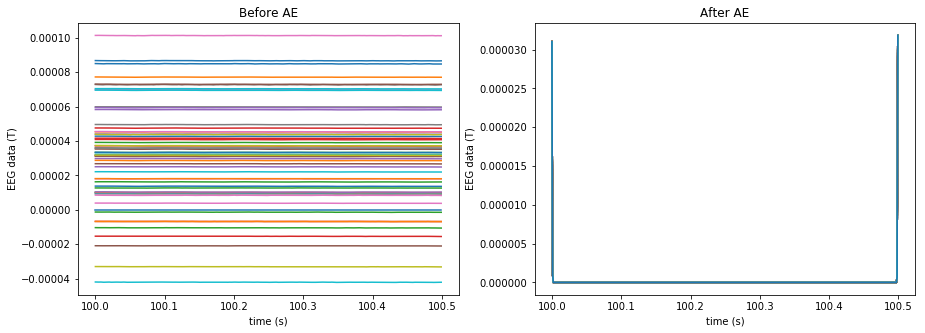

[[  3.10140094e-05   1.01841977e-06   9.11373643e-09 ...,   7.73356224e-09
    7.01472118e-07   3.18319217e-05]
 [  3.10140094e-05   1.01841977e-06   9.11373643e-09 ...,   7.73356224e-09
    7.01472118e-07   3.18319217e-05]
 [  3.10140094e-05   1.01841977e-06   9.11373643e-09 ...,   7.73356224e-09
    7.01472118e-07   3.18319217e-05]
 ..., 
 [  3.10140094e-05   1.01841977e-06   9.11373643e-09 ...,   7.73356224e-09
    7.01472118e-07   3.18319217e-05]
 [  3.10140094e-05   1.01841977e-06   9.11373643e-09 ...,   7.73356224e-09
    7.01472118e-07   3.18319217e-05]
 [  3.10140094e-05   1.01841977e-06   9.11373643e-09 ...,   7.73356224e-09
    7.01472118e-07   3.18319217e-05]]


In [41]:
start, stop = raw.time_as_index([100, 100.5])  # 100 s to 120 s data segment
_, times = raw[:, start:stop]

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(times, (x_tests[321].astype('float32')/255.).T)
plt.xlabel('time (s)')
plt.ylabel('EEG data (T)')
plt.title('Before AE')

print(x_pred.shape)
plt.subplot(1,2,2)
plt.plot(times, np.squeeze(x_pred, axis=2).T)
plt.xlabel('time (s)')
plt.ylabel('EEG data (T)')
plt.title('After AE')
plt.show()

print(np.squeeze(x_pred, axis=2))